# Studies of data reuse: Characterizing the input impedance spectrum of pyramidal cells from the intracellular recordings in response to sinuisoidal inputs

In this notebook we will look more closely at the EBRAINS dataset "[Characterizing the input impedance spectrum of pyramidal cells from the intracellular recordings in response to sinuisoidal inputs](https://search.kg.ebrains.eu/?category=Dataset&q=zerlaut#5a95ceb4-e303-42e3-9558-83b9ccb45976)", contributed by Yann Zerlaut from the Centre National de la Recherche Scientifique in Gif sur Yvettes, Franc.

As we can see from the dataset description,

<i>This dataset provides a characterization of recordings of Cellular Input Impedance in Layer V Pyramidal cells of Mouse V1 using patch-clamp recordings in brain slices.</i>
More information is available in the [Data Descriptor](https://search.kg.ebrains.eu/?category=Dataset&q=zerlaut#5a95ceb4-e303-42e3-9558-83b9ccb45976).

This dataset forms part of the results reported in Zerlaut Y, Destexhe A (2017) Heterogeneous firing responses predict diverse couplings to presynaptic activity in mice layer V pyramidal neurons. *PLOS Computational Biology* **13**(4). https://doi.org/10.1371/journal.pcbi.1005452

In this notebook we will demonstrate how to access the data files and the metadata from this study, and how these data can be analysed and visualised, with the goal of reproducing some of the figures from the article. 


### Notes: 

Easy to reuse the data. Code made available by the researchers

In [1]:
import os
import matplotlib.pylab as plt
import numpy as np
from pprint import pprint
from pynwb import NWBHDF5IO # need pynwb, see https://pynwb.readthedocs.io/en/latest/index.html
import scipy, pynwb
print(scipy.__version__)
print(pynwb.__version__)

/home/isaurebotherel/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


1.9.3
2.2.0


In [2]:
def load_data(mouse, cell,
              folder=os.path.join('..', 'data', 'Wild_Type')):
    fn = os.path.join(folder, "Mouse%i" % mouse, "Cell%i.nwb" % cell)
    try:
        io = NWBHDF5IO(fn, 'r')
        nwbfile = io.read()
        data = {'Iinjected': np.array(nwbfile.stimulus['ccss'].data),
                'Vm' : np.array(nwbfile.acquisition['ccs'].data),
                'freq' : np.array(nwbfile.stimulus['freqs'].data),
                'amp' : np.array(nwbfile.stimulus['amps'].data),
                'dt': 1./nwbfile.acquisition['ccs'].rate,
                'intervals' : np.array(nwbfile.acquisition['Freq-Intervals'].timestamps).reshape(-1,2)}
        io.close()
    except (FileNotFoundError, OSError):
        print('/!\ File:', fn, 'not found /!\ ')
    return data

In [4]:
cd /home/isaurebotherel/Bureau/Study of data reuse/complete/Zerlaut (almost complete)/Input-Impedance_L5PyrMiceV1_pub/code

/home/isaurebotherel/Bureau/Study of data reuse/complete/Zerlaut (almost complete)/Input-Impedance_L5PyrMiceV1_pub/code


In [5]:
data = load_data(3, 1)

/home/isaurebotherel/.local/lib/python3.8/site-packages/pynwb/icephys.py:22: UserWarning: Unit 'mV' for CurrentClampSeries 'ccs' is ignored and will be set to 'volts' as per NWB 2.1.0.
  warnings.warn(
/home/isaurebotherel/.local/lib/python3.8/site-packages/pynwb/icephys.py:22: UserWarning: Unit 'pA' for CurrentClampStimulusSeries 'ccss' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(


In [6]:
def show_full_data_subsampled(data):
    plt.figure(figsize=(22.,5.))
    plt.subplot2grid((3,1), (0,0), rowspan=2) # plotting sub-sampled data:
    plt.plot(data['dt']*np.arange(len(data['Vm']))[::100], data['Vm'][::100], label='Vm')
    plt.plot(data['intervals'][:,0], plt.ylim()[0]+0.*data['intervals'][:,0], 'r|', ms=15, label='shift of \ninput freq');plt.legend(loc=(1.01,.4))
    plt.subplot2grid((3,1), (2,0), rowspan=1) # plotting sub-sampled data:
    plt.plot(data['dt']*np.arange(len(data['Vm']))[::100], data['Iinjected'][::100], 'y', label='I-input')
    plt.legend(loc=(1.01,.2));

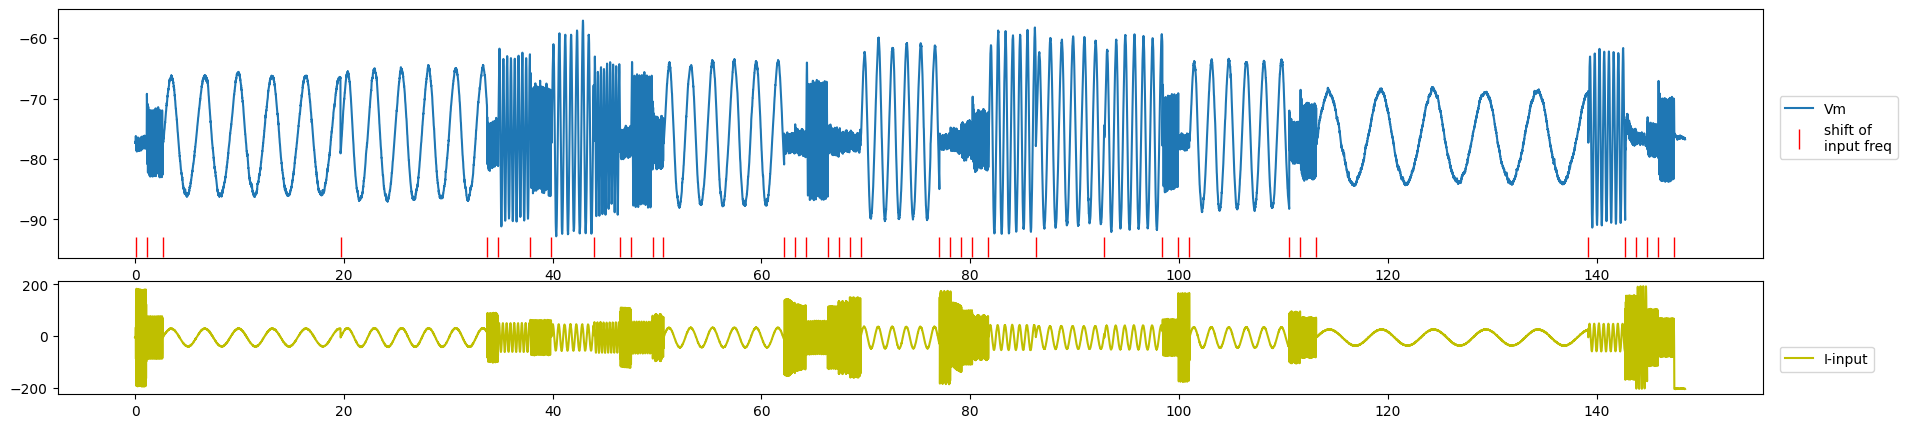

In [7]:
show_full_data_subsampled(data)

## Perform fitting of response amplitude

In [8]:
from scipy.optimize import minimize

def fit_response_envelope_in_intervals(data, list_of_interval_indices, with_plot=False):
    """
    least-square minimization to find the amplitude and phase of the cellular response
    """
    MODULUS, PHASE, FREQ = [], [], []
    if with_plot:
        fig, AX = plt.subplots(2, len(list_of_interval_indices), figsize=(3.*len(list_of_interval_indices), 4))
        AX[0][0].set_ylabel('Vm response (mV)')
        AX[1][0].set_ylabel('current input (pA)')
        for il in range(len(list_of_interval_indices)):
            AX[1][il].set_xlabel('time (s)')
    for i_plot, i_interval in enumerate(list_of_interval_indices):
        t1, t2 = data['intervals'][i_interval]
        tmean = .5*(t1+t2)
        t1G = np.max([t1+0.1,tmean-3./data['freq'][i_interval]])
        t2G = np.min([t2+0.1,tmean+3./data['freq'][i_interval]])
        cond = (data['dt']*np.arange(len(data['Vm']))>t1G) & (data['dt']*np.arange(len(data['Vm']))<t2G)
        t, vec, vec0 = data['dt']*np.arange(len(data['Vm']))[cond], data['Vm'][cond], data['Iinjected'][cond]
        if len(t)>0: # if enough time to fit (see t1 t2 conditions)
            # fitting the input to a sinusoid (to get the phase wrt "t")
            def sin0(X):
                return data['amp'][i_interval]*np.sin(2.*np.pi*data['freq'][i_interval]*(t-X[0]))
            def sin_residual0(X):
                return np.sum((sin0(X)-vec0)**2)
            res0 = minimize(sin_residual0, [t[0]], method='Nelder-Mead', tol=1e-6)
            # now fitting the response (amplitude and phase shift)
            def sin(X):
                return X[0]*np.sin(2.*np.pi*data['freq'][i_interval]*(t-res0.x[0]-X[2]))+X[1]
            def sin_residual(X):
                return np.sum((sin(X)-vec)**2)
            res = minimize(sin_residual, [5., -80., 0.], method='Nelder-Mead', tol=1e-6)
            if with_plot:
                AX[0][i_plot].set_title('interval %i' % i_interval)
                AX[0][i_plot].plot(t, vec, t, sin(res.x))
                AX[1][i_plot].plot(t, vec0, t, sin0(res0.x))
            else:
                # returns the input impedance characteristics
                if res.success:
                    modulus = 1000.*res.x[0]/data['amp'][i_interval] # in 1000*mV/pA==MOhm
                    phase = ((2.*np.pi*data['freq'][i_interval]*res.x[2])+np.pi/8.)%(2.*np.pi)-np.pi/8. # the +/- thing is to avoid huge jumps around 0 (a noisy estimate of 0 is 2.pi)
                    FREQ.append(data['freq'][i_interval])
                    if modulus>0:
                        MODULUS.append(modulus)
                        PHASE.append(phase)
                    else:
                        MODULUS.append(-modulus)
                        PHASE.append((phase+np.pi)%(2.*np.pi))

    return np.array(FREQ), np.array(MODULUS), np.array(PHASE)


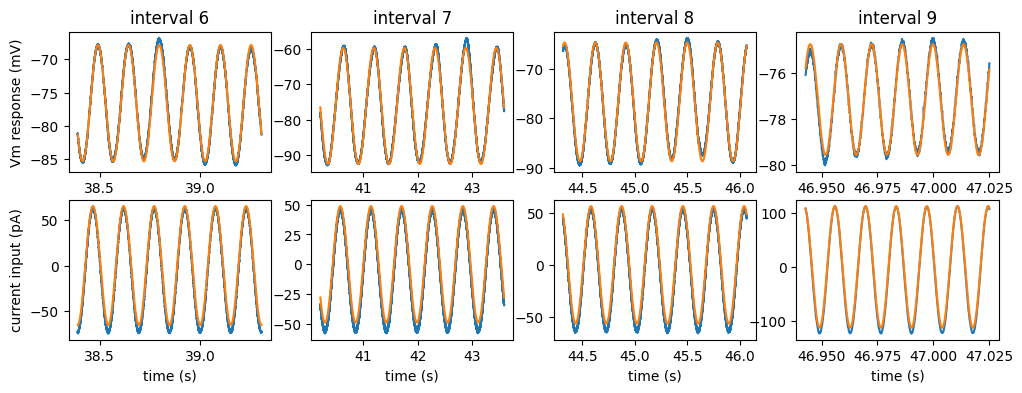

In [24]:
fit_response_envelope_in_intervals(data, np.arange(6, 10), with_plot=True);

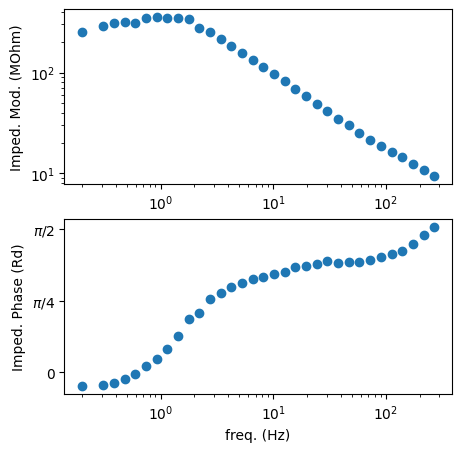

In [25]:
data['imped_freq'], data['imped_modulus'], data['imped_phase'] = fit_response_envelope_in_intervals(data, range(len(data['intervals']))[1:])

def plot_imped(data, with_plot=False,
               min_freq=0, max_freq=300.):
    fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5,5))
    cond = (data['imped_freq']>=min_freq) & (data['imped_freq']<=max_freq)
    ax1.loglog(data['imped_freq'][cond], data['imped_modulus'][cond], 'o')
    ax2.semilogx(data['imped_freq'][cond], data['imped_phase'][cond], 'o')
    ax1.set_ylabel('Imped. Mod. (MOhm)')
    ax2.set_ylabel('Imped. Phase (Rd)')
    ax2.set_yticks([0,np.pi/4.,np.pi/2.])
    ax2.set_yticklabels(['0', '$\pi$/4', '$\pi$/2'])
    ax2.set_xlabel('freq. (Hz)')
    return fig

plot_imped(data);

/home/isaurebotherel/.local/lib/python3.8/site-packages/pynwb/icephys.py:22: UserWarning: Unit 'mV' for CurrentClampSeries 'ccs' is ignored and will be set to 'volts' as per NWB 2.1.0.
  warnings.warn(
/home/isaurebotherel/.local/lib/python3.8/site-packages/pynwb/icephys.py:22: UserWarning: Unit 'pA' for CurrentClampStimulusSeries 'ccss' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(


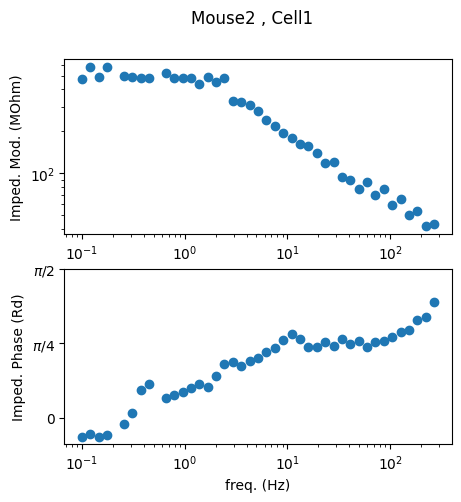

In [33]:
mouse, cell = 2, 1
data = load_data(mouse, cell)
data['imped_freq'], data['imped_modulus'], data['imped_phase'] = fit_response_envelope_in_intervals(data, range(len(data['intervals']))[1:])
fig = plot_imped(data)
fig.suptitle('Mouse%i , Cell%i' % (mouse, cell));

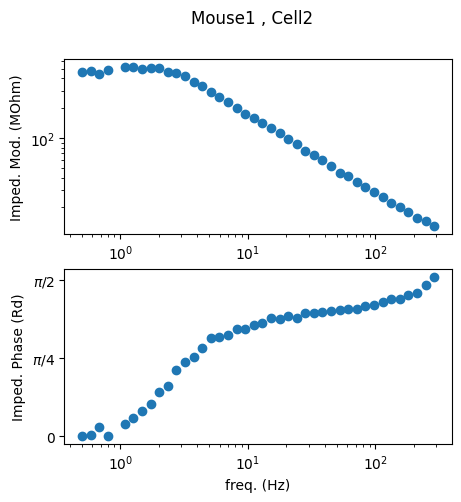

In [34]:
mouse, cell = 1, 2
data = load_data(mouse, cell)
data['imped_freq'], data['imped_modulus'], data['imped_phase'] = fit_response_envelope_in_intervals(data, range(len(data['intervals']))[1:])
fig = plot_imped(data)
fig.suptitle('Mouse%i , Cell%i' % (mouse, cell));

# Building and visualizing the full dataset

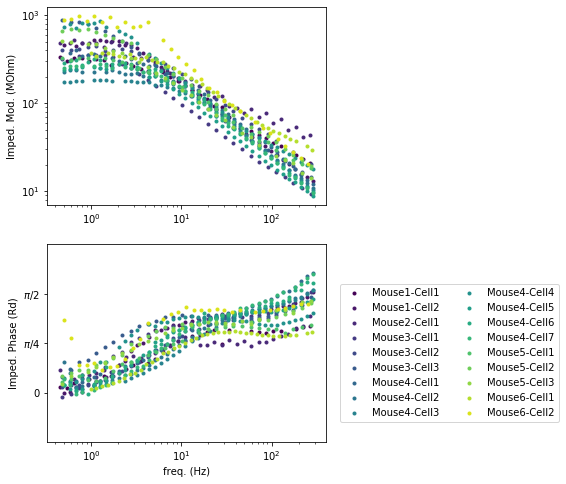

In [26]:
MOUSE_CELL = [( 1 , 1 ), ( 1 , 2 ),
              ( 2 , 1 ),
              ( 3 , 1 ),( 3 , 2 ),( 3 , 3 ),
              ( 4 , 1 ),( 4 , 2 ),( 4 , 3 ),( 4 , 4 ),( 4 , 5 ),( 4 , 6 ),( 4 , 7 ),
              ( 5 , 1 ),( 5 , 2 ),( 5 , 3 ),
              ( 6 , 1 ),( 6 , 2 )]

fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5,8))

min_freq, max_freq= 0.4, 300.
from matplotlib.cm import viridis

for n, (mouse, cell) in enumerate(MOUSE_CELL):
    data = load_data(mouse, cell)
    data['imped_freq'], data['imped_modulus'], data['imped_phase'] = fit_response_envelope_in_intervals(data, range(len(data['intervals']))[1:])
    cond = (data['imped_freq']>=min_freq) & (data['imped_freq']<=max_freq)
    ax1.loglog(data['imped_freq'][cond], data['imped_modulus'][cond], 'o', color=viridis(n/len(MOUSE_CELL)), ms=3)
    ax2.semilogx(data['imped_freq'][cond], data['imped_phase'][cond], 'o', color=viridis(n/len(MOUSE_CELL)), label='Mouse%i-Cell%i' % (mouse, cell), ms=3)

ax1.set_ylabel('Imped. Mod. (MOhm)')
ax2.set_ylabel('Imped. Phase (Rd)')
ax2.set_yticks([0,np.pi/4.,np.pi/2.])
ax2.set_ylim([-np.pi/4.,1.5*np.pi/2.])
ax2.set_yticklabels(['0', '$\pi$/4', '$\pi$/2'])
ax2.set_xlabel('freq. (Hz)')
ax2.legend(loc=(1.05, 0.1), ncol=2)        